In [1]:
import gym

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.ticker import (MultipleLocator, 
                               FormatStrFormatter, 
                               AutoMinorLocator) 

from lcs import Perception
from lcs.agents import EnvironmentAdapter
from lcs.metrics import population_metrics

import lcs.agents.acs2 as acs2
import lcs.agents.aacs2 as aacs2
import lcs.agents.acs2ar as acs2ar

import random
from collections import namedtuple

# Logger
import logging
logging.basicConfig(level=logging.INFO)

import gym_grid
grid20 = gym.make('grid-20-v0')
grid40 = gym.make('grid-40-v0')

In [2]:
def common_metrics(agent, env):
    pop = agent.get_population()

    metrics = {
        'agent': agent.__class__.__name__,
        'reliable': len([cl for cl in pop if cl.is_reliable()]),
    }

    if hasattr(agent, 'rho'):
        metrics['rho'] = agent.rho
    else:
        metrics['rho'] = 0

    metrics.update(population_metrics(pop, env))
    return metrics

In [3]:
# SET THE ENVIRONMENT
env = grid20

state_to_actions = env.env._state_action()
len(state_to_actions)

400

In [4]:
StateAction = namedtuple('StateAction', 'id state action')

state_action = []

idx = 1
for state, actions in state_to_actions.items():
    if len(actions) > 0:
        for action in actions:
            state_action.append(StateAction(idx, state, action))
            idx += 1
            
len(state_action)

1518

In [5]:
state_action[:10]

[StateAction(id=1, state=('1', '1'), action=1),
 StateAction(id=2, state=('1', '1'), action=2),
 StateAction(id=3, state=('1', '2'), action=0),
 StateAction(id=4, state=('1', '2'), action=1),
 StateAction(id=5, state=('1', '2'), action=2),
 StateAction(id=6, state=('1', '3'), action=0),
 StateAction(id=7, state=('1', '3'), action=1),
 StateAction(id=8, state=('1', '3'), action=2),
 StateAction(id=9, state=('1', '4'), action=0),
 StateAction(id=10, state=('1', '4'), action=1)]

In [6]:
# create a dict id > perception (for q-learning)

unique_states = {sa.state for sa in state_action}
sp = {}
for idx, state in enumerate(unique_states):
    sp[idx] = state

In [7]:
def find_state_id(state):
    for sp_id, sp_state in sp.items():
        if sp_state == state:
            return sp_id
    return None

In [8]:
sp[164]

('2', '2')

# Agent estimations

In [9]:
learning_rate = 0.1
discount_factor = 0.95
epsilon = 0.1
zeta = 0.0001

In [ ]:
%%time

acs2_cfg = acs2.Configuration(2, 4,
                         do_ga=False,
                         beta=learning_rate,
                         epsilon=1-epsilon,
                         gamma=discount_factor,
                         biased_exploration_prob=0.8)


acs2_agent = acs2.ACS2(acs2_cfg)
acs2_population, _ = acs2_agent.explore(env, 1500)

In [ ]:
%%time

aacs2_cfg = aacs2.Configuration(2, 4,
                         do_ga=False,
                         beta=learning_rate,
                         epsilon=1-epsilon,
                         gamma=discount_factor,
                         biased_exploration_prob=0.8)


aacs2_agent = aacs2.AACS2(aacs2_cfg)
aacs2_population, _ = aacs2_agent.explore_exploit(env, 3000)

In [ ]:
ns = find_state_id(('19', '15'))

Q[ns, :]

In [24]:
%%time

acs2ar_cfg = acs2ar.Configuration(2, 4,
                         do_ga=False,
                         beta=learning_rate,
                         epsilon=1-epsilon,
                         gamma=discount_factor,
                         zeta=zeta,
                         biased_exploration_prob=0.8)


acs2ar_agent = acs2ar.ACS2AR(acs2ar_cfg)
acs2ar_population, _ = acs2ar_agent.explore_exploit(env, 3000)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 1654, 'reward': 1000}
INFO:lcs.agents.Agent:{'trial': 300, 'steps_in_trial': 286, 'reward': 1000}
INFO:lcs.agents.Agent:{'trial': 600, 'steps_in_trial': 1701, 'reward': 1000}
INFO:lcs.agents.Agent:{'trial': 900, 'steps_in_trial': 2000, 'reward': 0}
INFO:lcs.agents.Agent:{'trial': 1200, 'steps_in_trial': 1959, 'reward': 1000}
INFO:lcs.agents.Agent:{'trial': 1500, 'steps_in_trial': 2000, 'reward': 0}
INFO:lcs.agents.Agent:{'trial': 1800, 'steps_in_trial': 2000, 'reward': 0}
INFO:lcs.agents.Agent:{'trial': 2100, 'steps_in_trial': 358, 'reward': 1000}
INFO:lcs.agents.Agent:{'trial': 2400, 'steps_in_trial': 2000, 'reward': 0}
INFO:lcs.agents.Agent:{'trial': 2700, 'steps_in_trial': 1567, 'reward': 1000}


CPU times: user 26min 9s, sys: 1.5 s, total: 26min 10s
Wall time: 26min 13s


In [ ]:
%%time

# Q = np.zeros((len(sp), env.action_space.n))
episodes = 50000

print(f"All elements\t: {Q.shape[0] * Q.shape[1]}")

for i in range(1, episodes):
#     print(f"\nEPISODE {i}")

    if i % 5000 == 0:
        print(f"Episode {i}")
        print(f"\tNon zero\t: {np.count_nonzero((Q))}")
        
    obs = env.reset()
    state = find_state_id(obs)
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state, :])
            
        next_obs, reward, done, info = env.step(action)
        next_state = find_state_id(next_obs)
        
#         if reward != 0:
#             print(f"******* REWARD ******* ")
        
        if next_state is not None:
            discounted = np.max(Q[next_state, :])
        else:
            discounted = 0
        
        Q[state, action] = Q[state, action] + learning_rate * (reward + discount_factor * discounted - Q[state, action])
        
#         print(f"{state} == ({action}) ==> {next_state} (r: {reward})\tQ[{state}, {action}]: {Q[state, action]}")
        state = next_state

In [20]:
%%time

episodes = 50_000

R = np.zeros((len(sp), env.action_space.n))
rho = 0

for i in range(1, episodes):
    state = find_state_id(env.reset())

    if i % 1000 == 0:
        print(f"\tEpisode {i}. Non zero\t: {np.count_nonzero((R))}")

    was_greedy = False
    done = False

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(R[state, :])
            was_greedy = True

        next_state, reward, done, info = env.step(action)
        next_state = find_state_id(next_state)

        if next_state is not None:
            discounted = np.max(R[next_state, :])
        else:
            discounted = 0

        R[state, action] = R[state, action] + learning_rate * (reward - rho + discounted - R[state, action])

        if was_greedy:
            rho = rho + zeta * (reward + np.max(R[next_state, :]) - discounted - rho)

        state = next_state 

	Episode 1000. Non zero	: 0
	Episode 2000. Non zero	: 0
	Episode 3000. Non zero	: 0
	Episode 4000. Non zero	: 0
	Episode 5000. Non zero	: 0
	Episode 6000. Non zero	: 0
	Episode 7000. Non zero	: 0
	Episode 8000. Non zero	: 0
	Episode 9000. Non zero	: 1
	Episode 10000. Non zero	: 1596
	Episode 11000. Non zero	: 1596
	Episode 12000. Non zero	: 1596
	Episode 13000. Non zero	: 1596
	Episode 14000. Non zero	: 1596
	Episode 15000. Non zero	: 1596
	Episode 16000. Non zero	: 1596
	Episode 17000. Non zero	: 1596
	Episode 18000. Non zero	: 1596
	Episode 19000. Non zero	: 1596
	Episode 20000. Non zero	: 1596
	Episode 21000. Non zero	: 1596
	Episode 22000. Non zero	: 1596
	Episode 23000. Non zero	: 1596
	Episode 24000. Non zero	: 1596
	Episode 25000. Non zero	: 1596
	Episode 26000. Non zero	: 1596
	Episode 27000. Non zero	: 1596
	Episode 28000. Non zero	: 1596
	Episode 29000. Non zero	: 1596
	Episode 30000. Non zero	: 1596
	Episode 31000. Non zero	: 1596
	Episode 32000. Non zero	: 1596
	Episode 330

# Payoff landscape

In [25]:
%%time

payoffs = {}

for sa in state_action:
    p = Perception(sa.state)
    
    # ACS2
#     acs2_match_set = acs2_population.form_match_set(p)
#     acs2_action_set = acs2_match_set.form_action_set(sa.action)
    
    # AACS2
#     aacs2_match_set = aacs2_population.form_match_set(p)
#     aacs2_action_set = aacs2_match_set.form_action_set(sa.action)
    
    # ACS2AR
    acs2ar_match_set = acs2ar_population.form_match_set(p)
    acs2ar_action_set = acs2ar_match_set.form_action_set(sa.action)
    
    payoffs[sa] = {
#         'acs2': np.mean(list(map(lambda cl: cl.r, acs2_action_set))),
#         'aacs2': np.mean(list(map(lambda cl: cl.r, aacs2_action_set))),
        'acs2ar': np.mean(list(map(lambda cl: cl.r, acs2ar_action_set))),
#         'q-learning': Q[find_state_id(sa.state), sa.action],
        'r-learning': R[find_state_id(sa.state), sa.action]
    }

CPU times: user 473 ms, sys: 9.75 ms, total: 482 ms
Wall time: 520 ms


## Plot results

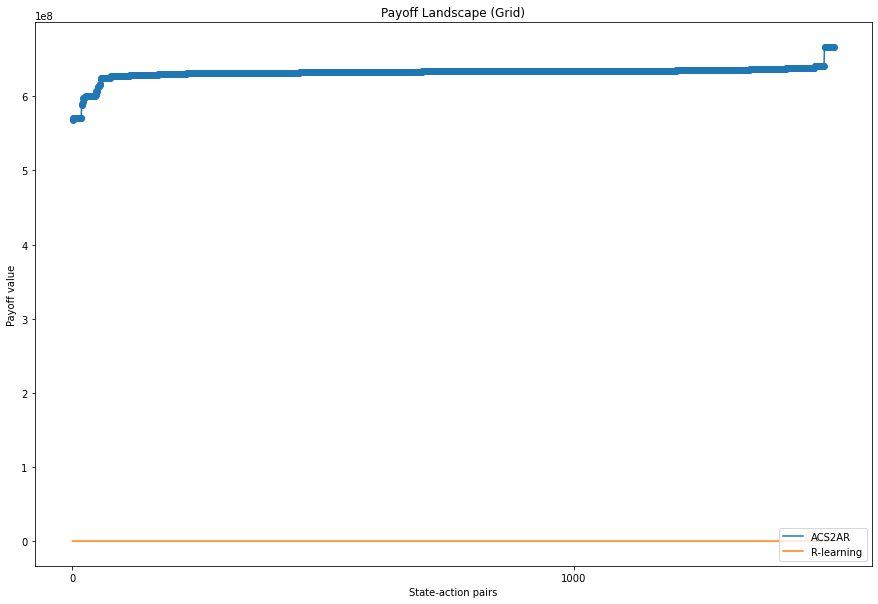

In [26]:
fig, ax = plt.subplots(figsize=(15, 10))

x = range(1, len(payoffs)+1)
# y_acs2 = sorted([v['acs2'] for k, v in payoffs.items()])
# y_aacs2 = sorted([v['aacs2'] for k, v in payoffs.items()])
y_acs2ar = sorted([v['acs2ar'] for k, v in payoffs.items()])
# y_qlearning = sorted([v['q-learning'] for k, v in payoffs.items()])
y_rlearning = sorted([v['r-learning'] for k, v in payoffs.items()])

# ACS2
# plt.scatter(x, y_acs2)
# plt.plot(x, y_acs2, label='ACS2')

# AACS2
# plt.scatter(x, y_aacs2)
# plt.plot(x, y_aacs2, label='AACS2')

# ACS2AR
# plt.scatter(x, y_acs2ar)
# plt.plot(x, y_acs2ar, label='ACS2AR')

# Q-learning
# plt.scatter(x, y_qlearning)
# plt.plot(x, y_qlearning, label='Q-learning')

# R-learning
# plt.scatter(x, y_rlearning)
plt.plot(x, y_rlearning, label='R-learning')

ax.xaxis.set_major_locator(MultipleLocator(1000)) 
ax.xaxis.set_major_formatter(FormatStrFormatter('%1.0f')) 

ax.set_xlabel("State-action pairs")
ax.set_ylabel("Payoff value")
ax.set_title("Payoff Landscape (Grid)")

ax.legend(loc='lower right')

plt.show()